In [29]:
data_dir = '../data/aclImdb'
data_dir

'../data/aclImdb'

In [30]:
import os


def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8', errors='ignore').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels


train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)
print('训练集数目：', len(train_data[0]))
print('测试集数目：', len(test_data[0]))

训练集数目： 25000
测试集数目： 25000


将每个单词作为一个词元，过滤掉出现不到5次的单词，从训练数据集中创建一个词表。

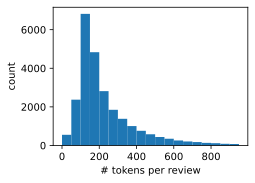

In [31]:
from d2l.torch import d2l

train_tokens = d2l.tokenize(train_data[0], token='word')
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [ ]:
# train_data = read_imdb(data_dir, True)
# test_data = read_imdb(data_dir, False)
train_tokens = d2l.tokenize(train_data[0], token='word')
test_tokens = d2l.tokenize(test_data[0], token='word')

vocab = d2l.Vocab(train_tokens, min_freq=5)
# train_tokens

In [34]:
num_steps = 500  # 序列长度
batch_size = 64

train_features = d2l.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
test_features = d2l.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])

train_iter = d2l.load_array((train_features, d2l.tensor(train_data[1])),
                            batch_size)
test_iter = d2l.load_array((test_features, d2l.tensor(test_data[1])),
                           batch_size,
                           is_train=False)

In [35]:
from torch import nn


class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [36]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [37]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])


net.apply(init_weights);

In [38]:
# glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
import torch
import numpy as np


# 读取GloVe词向量文件
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings


# 从文件加载GloVe词向量
glove_file = '../data/glove.6B.100d/vec.txt'
glove_embeddings = load_glove_embeddings(glove_file)

# 构建词汇表并加载预训练的词向量
embedding_dim = len(next(iter(glove_embeddings.values())))
vocab_size = len(vocab)
glove_matrix = np.zeros((vocab_size, embedding_dim))

for idx, token in enumerate(vocab.idx_to_token):
    if token in glove_embeddings:
        glove_matrix[idx] = glove_embeddings[token]

# 创建嵌入层
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(glove_matrix), freeze=True)

In [39]:
# 获取词汇表中所有单词的嵌入表示
embeds = embedding_layer(torch.LongTensor(range(len(vocab))))

# 查看嵌入表示的形状
print(embeds.shape)

torch.Size([49346, 100])


In [40]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.198, train acc 0.923, test acc 0.854
1355.9 examples/sec on [device(type='cuda', index=0)]


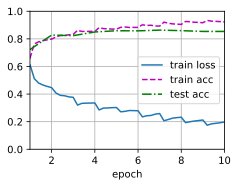

In [41]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices)

In [42]:
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [43]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [44]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [45]:
predict_sentiment(net, vocab, 'I think this movie is so terrible')

'negative'

In [46]:
net

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)